# Digital image archiving, APIs, and webscraping

![gallery](gallery.jpeg)

In [ ]:
import requests
import os
import re
import requests
import pandas as pd
import getpass
from urllib.parse import urlparse
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
import string
punct = list(string.punctuation)
import seaborn as sns
sns.set()

## How can we programmatically access images in a way that facilitates research?

An API (Application Programming Interface) is a set of rules and protocols that allows different software applications to communicate with each other. It defines how requests and responses should be structured, enabling developers to access and use the functionality of another service, library, or platform without needing to understand its internal workings.

APIs should be your go-to resource of choice when gathering large quantities of data, as they generally provide this data in structured form, allowing you to easily manipulate it.

Microsoft makes Bing image search available as an API; so do other search providers. The Bing API is useful because it gives good metadata on the images it finds. But first, let's look at a more intuitive API.

### The Project Gutenberg API

[Project Gutenberg](https://www.gutenberg.org/) provides electronic copies of large variety of out-of-copyright texts. It can be accessed using the [Gutendex API](https://gutendex.com/). The `requests` library in python can be used to query this API via the relevant parameters (see the documentation for what these are).  

In [ ]:
# Define the API root url:

gut = 'https://gutendex.com/books/'

In [ ]:
# Query by topic (here, 'death')

params = {'topic':'death'} 
death = requests.get(url = gut, params = params).json() # returns the results as a python dictionary

In [ ]:
death

In [ ]:
print(death['results'][2]['summaries'][0])

### Let's create functions that allow us to access the Bing API

* `search_images` gives a `dataframe` with all the relevant metadata
* `download` images allows you to download all the images you find to directory

In [ ]:

API_KEY = "c0ff1e51fbd14e598b44b3f9a76aee3d"
ENDPOINT = "https://api.bing.microsoft.com/v7.0/images/search"



def search_images(query_term, num_results):
    headers = {"Ocp-Apim-Subscription-Key": API_KEY}
    params = {"q": query_term, "count": num_results}
    response = requests.get(ENDPOINT, headers=headers, params=params)
    if response.status_code == 200:
        return pd.DataFrame(response.json().get('value', []))
    else:
        print("Error:", response.status_code, response.text)
        return []




def download_images(image_urls, save_dir, max_images=None):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Limit the number of images to download if max_images is specified
    if max_images:
        image_urls = image_urls[:max_images]
    
    for i, url in enumerate(image_urls):
        try:
            # Get the image data
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an error for bad responses (4xx and 5xx)
            
            # Define the filename and save path
            parsed_url = urlparse(url)
            filename = os.path.basename(parsed_url.path)
            filepath = os.path.join(save_dir, filename)
            
            # Write the image data to the file
            with open(filepath, "wb") as file:
                for chunk in response.iter_content(1024):  # Download in chunks
                    file.write(chunk)
        except:
            pass




In [ ]:
# Get a dataframe of 10 images of Lenin

images = search_images("lenin", 10)

In [ ]:
# Download the 10 Lenin images

In [ ]:
images_urls = []

for i in images['contentUrl']:
    images_urls.append(i)

download_images(images_urls, "Reform_archive/")

## What can we do with this data? First, let's see if we can extract some high-level colour features across images.

In [ ]:
hex_codes = ['#'+i for i in images['accentColor']] # add hash to make hex codes valid

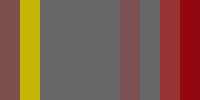

In [56]:
from PIL import Image, ImageDraw

# Create a blank image
width, height = 200, 100
palette_width = width // len(hex_codes)
image_palette = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image_palette)

# Draw each color as a rectangle
for i, colour in enumerate(hex_codes):
    draw.rectangle([i * palette_width, 0, (i + 1) * palette_width, height], fill=colour)

#image_palette.show()  # Opens the image in a viewer
image_palette  # Displays the image directly in the notebook

## How does the text on the image webpage match the image? Let's get the text

In [ ]:
import requests
from bs4 import BeautifulSoup

web_text = []

for i in images['hostPageUrl']:
    response = requests.get(i)
    soup = BeautifulSoup(response.text, "html.parser")
    text = soup.get_text()
    cleaned_text = re.sub(r'\n+', '\n', text)  # Collapse multiple newlines into one
    cleaned_text = re.sub(r'\t+', '', cleaned_text)  # Remove tabs
    cleaned_text = cleaned_text.strip()  # Remove leading/trailing whitespace
    cleaned_text = word_tokenize(cleaned_text)
    cleaned_text = [i.lower() for i in cleaned_text]
    cleaned_text = [lemmatizer.lemmatize(i) for i in cleaned_text]
    cleaned_text = [i for i in cleaned_text if i not in stops and i not in punct]
    web_text.append(cleaned_text)




### Now, let's measure the emotional variation of the text using the VAD norms

In [ ]:
vad = pd.read_csv('vad.csv', index_col = 0)  #VAD norms
vad = vad[["V.Mean.Sum", "A.Mean.Sum", "D.Mean.Sum"]]
vad.columns = ['valence', 'arousal', 'dominance']

def vad_data(word_list):
    word_list = [i.lower() for i in word_list]
    words = []
    norms = []
    
    for i in word_list:
        if i in vad.index:
            norms.append(vad.loc[i])
            words.append(i)
        else:
            pass
    norms_vad = pd.DataFrame(norms).mean()
    return norms_vad

In [ ]:
web_norms = pd.DataFrame([vad_data(i) for i in web_text])

In [ ]:
images = pd.concat([images, web_norms], axis = 1)

In [ ]:
images

In [ ]:
sns.barplot(x = images.index, y = 'dominance', data = images)